<a href="https://colab.research.google.com/github/DavidTorresP5/UZ_challenge/blob/main/UserZoom_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# UserZoom - David Torres

## Code challenge

### Libraries

In [1]:
"""
Upload the packages for the exercise 
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier

In [2]:
"""
Load the main csv and print shape 
"""

df_ini = pd.read_csv("CollegeScorecard.csv")
print(df_ini.shape)

(7804, 1725)


/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning:

Columns (7,9,1427,1542,1561,1575) have mixed types.Specify dtype option on import or set low_memory=False.



In [29]:
"""
Analyze the dataframe
"""
# df_ini.describe()
# df_ini.loc[:,df_ini.columns.str.contains('UGDS')].head()

'\nAnalyze the dataframe\n'

In [30]:
def get_missing_vals(df,na_threshold=0): 
  """
  Print the number of columns with a % of NAs over a selected threshold
  """
  missing_val_df = pd.DataFrame({'column_name': df.columns,
                                 'perc_na': df.isnull().sum() * 100 / len(df)})
  print(missing_val_df[missing_val_df.perc_na > na_threshold].shape[0])

In [31]:
get_missing_vals(df_ini,na_threshold=15)

1341


### Preprocess
After analyzing the data we will perform a preprocessing prior to the application of the segmentation algorithm.

- First we will eliminate those columns with more than 15% of NAs.
- Then we will keep only the columns loaded as numerical, after assessing in the documentation that the categorical ones do not seem very interesting.
- Then we eliminate columns that include certain text strings.
- Finally we remove columns with very low variance.


In [8]:

perc_na = .15
perc_var = .01
df = df_ini.dropna( axis=1, 
                thresh=int((1-perc_na)*df_ini.shape[0] + 1))
df_nums = df.select_dtypes(include=np.number)
df_nums = df_nums.loc[:,~df_nums.columns.str.contains('CERT')]
df_nums = df_nums.loc[:,~df_nums.columns.str.contains('BACH')]
df_nums = df_nums.loc[:,~df_nums.columns.str.contains('ASSOC')]
df_nums = df_nums.drop(['OPEID','opeid6'],axis=1)


var_threshold = VarianceThreshold(threshold=perc_var)
var_threshold.fit(df_nums)
df_nums = df_nums[df_nums.columns[var_threshold.get_support(indices=True)]]

df_nums.shape

(7804, 32)

We are left with 32 columns for now, although UNITID will have to be removed later.

In [9]:
df_nums.head()

,UNITID,main,NUMBRANCH,PREDDEG,HIGHDEG,CONTROL,st_fips,region,LOCALE,LATITUDE,LONGITUDE,HBCU,HSI,PCIP12,PCIP24,PCIP39,PCIP47,PCIP50,PCIP51,PCIP52,UGDS,UGDS_WHITE,UGDS_BLACK,UGDS_HISP,UGDS_UNKN,PPTUG_EF,CURROPER,TUITFTE,INEXPFTE,PCTPELL,PCTFLOAN,UG25abv
0,100654,1,1,3,4,1,1,5,12.0,34.7834,-86.5685,1.0,0.0,0.0,0.0546,0.0000,0.0,0.0166,0.0000,0.1457,4051.0,0.0279,0.9501,0.0089,0.0084,0.0622,1,9063.0,7459.0,0.7115,0.8204,0.1049
1,100663,1,1,3,4,1,1,5,12.0,33.5022,-86.8092,0.0,0.0,0.0,0.0262,0.0000,0.0,0.0415,0.2090,0.1765,11200.0,0.5987,0.2590,0.0258,0.0130,0.2579,1,9033.0,17208.0,0.3505,0.5397,0.2422
2,100690,1,1,3,4,2,1,5,12.0,32.3626,-86.1740,0.0,0.0,0.0,0.6301,0.2603,0.0,0.0000,0.0000,0.0685,322.0,0.2919,0.4224,0.0093,0.2671,0.3727,1,12057.0,5123.0,0.6839,0.7629,0.8540
3,100706,1,1,3,4,1,1,5,12.0,34.7228,-86.6384,0.0,0.0,0.0,0.0000,0.0000,0.0,0.0346,0.1720,0.2247,5525.0,0.7012,0.1310,0.0338,0.0338,0.2395,1,8322.0,9352.0,0.3281,0.4728,0.2640
4,100724,1,1,3,4,1,1,5,12.0,32.3643,-86.2957,1.0,0.0,0.0,0.0000,0.0000,0.0,0.0567,0.0633,0.1067,5354.0,0.0161,0.9285,0.0114,0.0138,0.0902,1,7813.0,7393.0,0.8265,0.8735,0.1270


Between the options of imputing (median) or eliminating rows with null values, we chose the second option because the results are better, even if we do not categorize all the institutions.

In [11]:
# Impute with the median
# df = df.apply(lambda x: x.fillna(x.median()),axis=0)
df_withnona = df_nums.dropna()
print(f"Removed rows with NAs: {df_withnona.shape}")

Removed rows with NAs: (6666, 32)


In [12]:
# We create a Dataframe with IDs for the final submission

df_output = pd.DataFrame({"UNITID": df_withnona.UNITID}) 
df_withnona = df_withnona.drop(['UNITID'],axis=1)

print(f"Removed id column: {df_withnona.shape}")


Removed id column: (6666, 31)


We standardize the data so that the k-means works properly.

In [13]:
scaler = StandardScaler()
scaled_features = scaler.fit_transform(df_withnona)

df_prepr = pd.DataFrame(scaled_features, index=df_withnona.index, columns=df_withnona.columns)
print(f"Applied Scaler: {df_prepr.shape}")

Applied Scaler: (6666, 31)


### K-means
We tried different number of clusters in the algorithm but we found that the silhouette score is quite low, so we propose to reduce the dimensionality using PCA.

We are left with 10 components and we launch a new k-means with 8 centroids, giving us a silhouette score of almost 24, so we keep this model: model_1

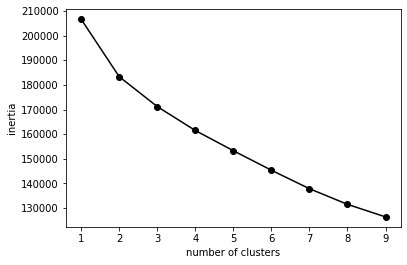

In [14]:
ks = range(1, 10)
inertias = []

for k in ks:
    model_0 = KMeans(n_jobs = -1, n_clusters=k)
    model_0.fit(df_prepr)
    inertias.append(model_0.inertia_)

plt.plot(ks, inertias, '-o', color='black')
plt.xlabel('number of clusters')
plt.ylabel('inertia')
plt.xticks(ks)
plt.show()

In [33]:
model_0 = KMeans(n_jobs = -1, n_clusters = 4, init='k-means++')
model_0.fit(df_prepr)

print(silhouette_score(df_prepr, model_0.labels_, metric='euclidean'))

0.12428807482569289


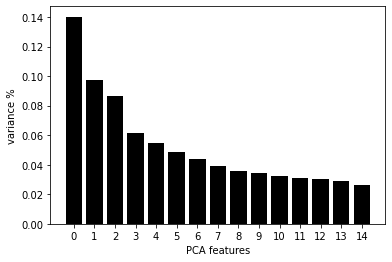

In [16]:
pca = PCA(n_components=15)
principalComponents = pca.fit_transform(df_prepr)

features = range(pca.n_components_)
plt.bar(features, pca.explained_variance_ratio_, color='black')
plt.xlabel('PCA features')
plt.ylabel('variance %')
plt.xticks(features)

PCA_components = pd.DataFrame(principalComponents)

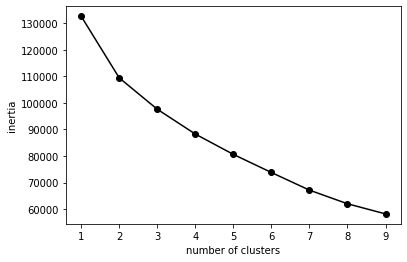

In [17]:
num_components = 10
ks = range(1, 10)
inertias = []

for k in ks:
    model_1 = KMeans(n_clusters=k)
    model_1.fit(PCA_components.iloc[:,:num_components])
    inertias.append(model_1.inertia_)

plt.plot(ks, inertias, '-o', color='black')
plt.xlabel('number of clusters')
plt.ylabel('inertia')
plt.xticks(ks)
plt.show()

In [18]:
model_1 = KMeans(n_clusters=8)
model_1.fit(PCA_components.iloc[:,:num_components])

# silhouette score
print(silhouette_score(PCA_components.iloc[:,:num_components], model_1.labels_, metric='euclidean')) 

0.23979567880844652


### Analysis
A very interesting way to obtain the most important variables when discriminating within a clustering algorithm such as k-means, is to perform an adjustment with a supervised classification algorithm, where we use as class the cluster assigned by k-means and as features the variables before the PCA.

Once the adjustment is done, in this case with a Decision Tree, we see the main variables that have contributed to the cuts.


In [19]:
clf = DecisionTreeClassifier()
clf.fit(df_prepr, model_1.labels_)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [20]:
importances = clf.feature_importances_

In [21]:
feat_importances = pd.Series(importances, index=df_prepr.columns).sort_values(ascending=False)
feat_importances.head(15)

PCIP12        0.190260
PREDDEG       0.178182
CONTROL       0.150180
UGDS_HISP     0.088795
NUMBRANCH     0.060673
PCIP51        0.056883
UGDS_WHITE    0.051865
LONGITUDE     0.027973
UGDS          0.026348
HBCU          0.017629
UG25abv       0.017181
TUITFTE       0.013311
LATITUDE      0.013120
PCTPELL       0.011321
UGDS_UNKN     0.010308
dtype: float64

In [22]:
df_withnona["Cluster_num"] = model_1.labels_
df_withnona["Cluster"] = df_withnona["Cluster_num"].astype(str)
df_withnona["Perc"] = 1

In [24]:
def barplot_var_by_clusters(var, title):
  """
  Barplot variable vs cluster group to see the effect of each case of the variable
  """
  tbl = df_withnona[['Cluster', var, 'Perc']].groupby(['Cluster', var]).count()
  tbl = tbl.groupby(level=0).apply(lambda x:100 * x / float(x.sum()))
  tbl.reset_index(inplace=True)
  fig = px.bar(tbl, x=var, y="Perc",color='Cluster', barmode='group',title=f"{title} by Cluster")
  fig.show()

def boxplot_var_by_cluster(var, title):
  """
  Boxplot: variable by cluster group
  """
  fig = px.box(df_withnona, x="Cluster", y=var, color="Cluster",title=f"{title} by Cluster")
  fig.show()

In [27]:
barplot_var_by_clusters("PREDDEG","Predominant degree awarded")
barplot_var_by_clusters("CONTROL","Type of school")

In [28]:
boxplot_var_by_cluster("NUMBRANCH","Number of branch campuses")
boxplot_var_by_cluster("PCIP12","% of degrees awarded in Personal And Culinary Serv.")
boxplot_var_by_cluster("PCIP24","% of degrees awarded in Liberal Arts")
boxplot_var_by_cluster("PCIP39","% of degrees awarded in Theology")
boxplot_var_by_cluster("PCIP51","% of degrees awarded in Health")
boxplot_var_by_cluster("UGDS_HISP","% undergraduate degree seeking Hispanic")
boxplot_var_by_cluster("UGDS_WHITE","% undergraduate degree seeking White")
boxplot_var_by_cluster("PCTFLOAN","% students with a federal loan")
boxplot_var_by_cluster("PPTUG_EF","% undergraduate degree seeking part-time")


After analyzing the different plots, we can summarize the composition of each cluster as follows:

* **Cluster 0** includes private for-profit institutions with a large number of branches, and with a very high percentage of students with federal loans.
* **Cluster 1** includes private for-profit culinary services training schools offering certificate-degrees.
* **Cluster 2** includes public institutions with many part-time students, with a high percentage of Liberal Arts students.
* **Cluster 3** includes private non-profit theological schools with a high percentage of white students offering bachelor's-degrees.
* **Cluster 4** includes private for-profit health institutions with a high percentage of students with federal loans.
* **Cluster 5** includes private for-profit institutions with a high percentage of Hispanic students.
* **Cluster 6** includes private non-profit institutions offering bachelor's-degrees with a high percentage of part-time white students.
* **Cluster 7** includes public or private non-profit institutions with a high percentage of federal loan students.







In [35]:
# Finally, we save out labels in a csv file
df_output["Cluster"] = model_1.labels_
df_output.to_csv("UserZoom_DavidTorres.csv",sep=",")
df_output.head()

,UNITID,Cluster
0,100654,7
1,100663,3
2,100690,2
3,100706,3
4,100724,7
